In [1]:
#!/usr/bin/env python

import numpy as np
from scipy.integrate import odeint, simps

def radial_schrod_deriv(u, r, l, E, Z=1):
    '''
    The radial Schrödinger equation for hydrogen-like atom is

        u''(x) - [(l(l+1)/x^2) - (2Z/x) - E]u(x) = 0 

    Since it is a second-order equation, i.e. 
    
        y'' + g(x)y(x) = 0

    To use scipy.integrate.odeint, we can turn this equation into two
    first-order equation by defining a new dependent variables
    
        y'(x) = z(x)
        z'(x) = -g(x)y(x)

    Then we can solve this system of ODEs using "odeint" wit list. 
    '''
    
    y, z = u

    return np.array([
        z, 
        ((l*(l+1) / r**2) - (2*Z / r) - E) * y
    ])


def radial_wfc_scipy(r0, n=1, l=0, Z=1, direction='F', du=0.1):
    '''
    Get the radial wavefunction by integrating the equation with
    scipy.integrate.odeint.
    '''

    assert direction.upper() in ['F', 'B']

    E = -Z**2 / n**2

    # forward integration 
    if direction.upper() == 'F':
        ur = odeint(radial_schrod_deriv, [0.0, du], r0, args=(l, E, Z))[:,0]

    # back integration 
    else:
        ur = odeint(radial_schrod_deriv, [0.0, -du], r0[::-1], args=(l, E, Z))[:,0][::-1]

    # normalization
    ur /= np.sqrt(simps(ur**2, x=r0))

    return ur


def radial_wfc_numerov(r0, n=1, l=0, Z=1, du=0.001):
    '''
    Numerov algorithm
    
                  [12 - 10f(n)]*y(n) - y(n-1)*f(n-1)
        y(n+1) = ------------------------------------
                               f(n+1)

    where
        
        f(n) = 1 + (h**2 / 12)*g(n)

        g(n) = [E + (2*Z / x) - l*(l+1) / x**2]
    '''

    ur = np.zeros(r0.size)
    fn = np.zeros(r0.size)

    E      = -Z**2 / n**2
    ur[-1] = 0.0
    ur[-2] = du

    dr  = r0[1] - r0[0]
    h12 = dr**2 / 12.

    gn = (E + 2*Z / r0 - l*(l+1) / r0**2)
    fn = 1. + h12 * gn

    for ii in range(r0.size - 3, -1, -1):
        ur[ii] = (12 - 10*fn[ii+1]) * ur[ii+1] - \
                 ur[ii+2] * fn[ii+2]
        ur[ii] /= fn[ii]

    # normalization
    ur /= np.sqrt(simps(ur**2, x=r0))

    return ur

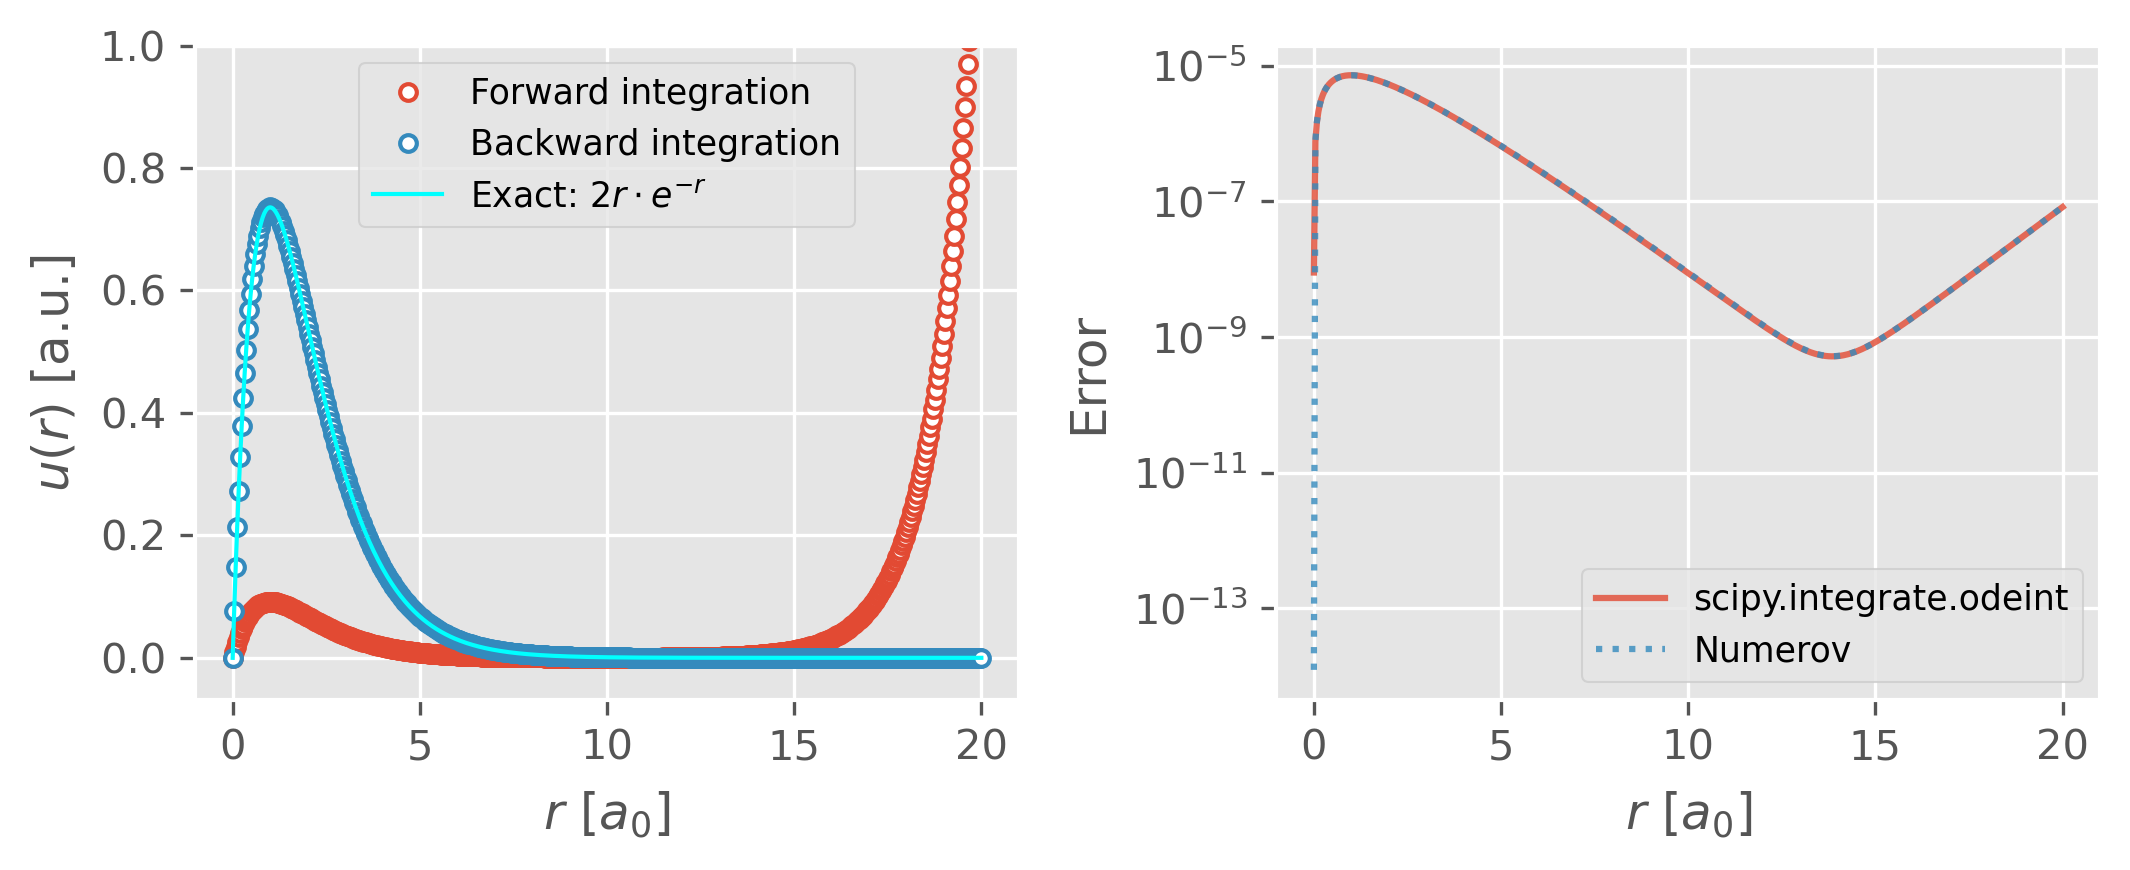

In [2]:
################################################################################
# Define the radial grid
r0 = np.linspace(1E-10, 20, 500)

Z = 1
l = 0
n = 1

# forward integration from u(0)
ur1 = radial_wfc_scipy(r0, n, l, direction='F')
# backward integration from u(\infty)
ur2 = radial_wfc_scipy(r0, n, l, direction='B')
# backward integration from u(\infty) with Numerov method
ur3 = radial_wfc_numerov(r0, n, l)

################################################################################
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(
    figsize=(7.2, 3.0),
    dpi=300
)
axes = [plt.subplot(1,2,ii+1) for ii in range(2)]

################################################################################
ax = axes[0]

ax.plot(
    r0, ur1,
    ls='none',
    ms=4, marker='o', mfc='white', mew=1.0, 
    zorder=1,
    label=r'Forward integration',
)

ax.plot(
    r0, ur2,
    ls='none',
    ms=4, marker='o', mfc='white', mew=1.0, 
    zorder=1,
    label=r'Backward integration',
)
ax.plot(r0, 2*r0*np.exp(-r0), lw=1.0, color='cyan', zorder=2, label=r'Exact: $2r\cdot e^{-r}$')

ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
ax.set_ylabel(r'$u(r)$ [a.u.]', labelpad=5)

ylim = list(ax.get_ylim())
ylim[1] = 1.0
ax.set_ylim(ylim)
ax.legend(loc='best', fontsize='small')

#################################################################################
ax = axes[1]

ax.semilogy(
    r0, 2*r0*np.exp(-r0) - ur2,
    ls='-', alpha=0.8,
    zorder=1,
    label=r'scipy.integrate.odeint',
)

ax.semilogy(
    r0, 2*r0*np.exp(-r0) - ur3,
    ls=':', alpha=0.8,
    zorder=1,
    label=r'Numerov',
)
ax.legend(loc='lower right', fontsize='small')

ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
ax.set_ylabel(r'Error', labelpad=5)

plt.tight_layout()
plt.savefig('fig1.png')
plt.show()

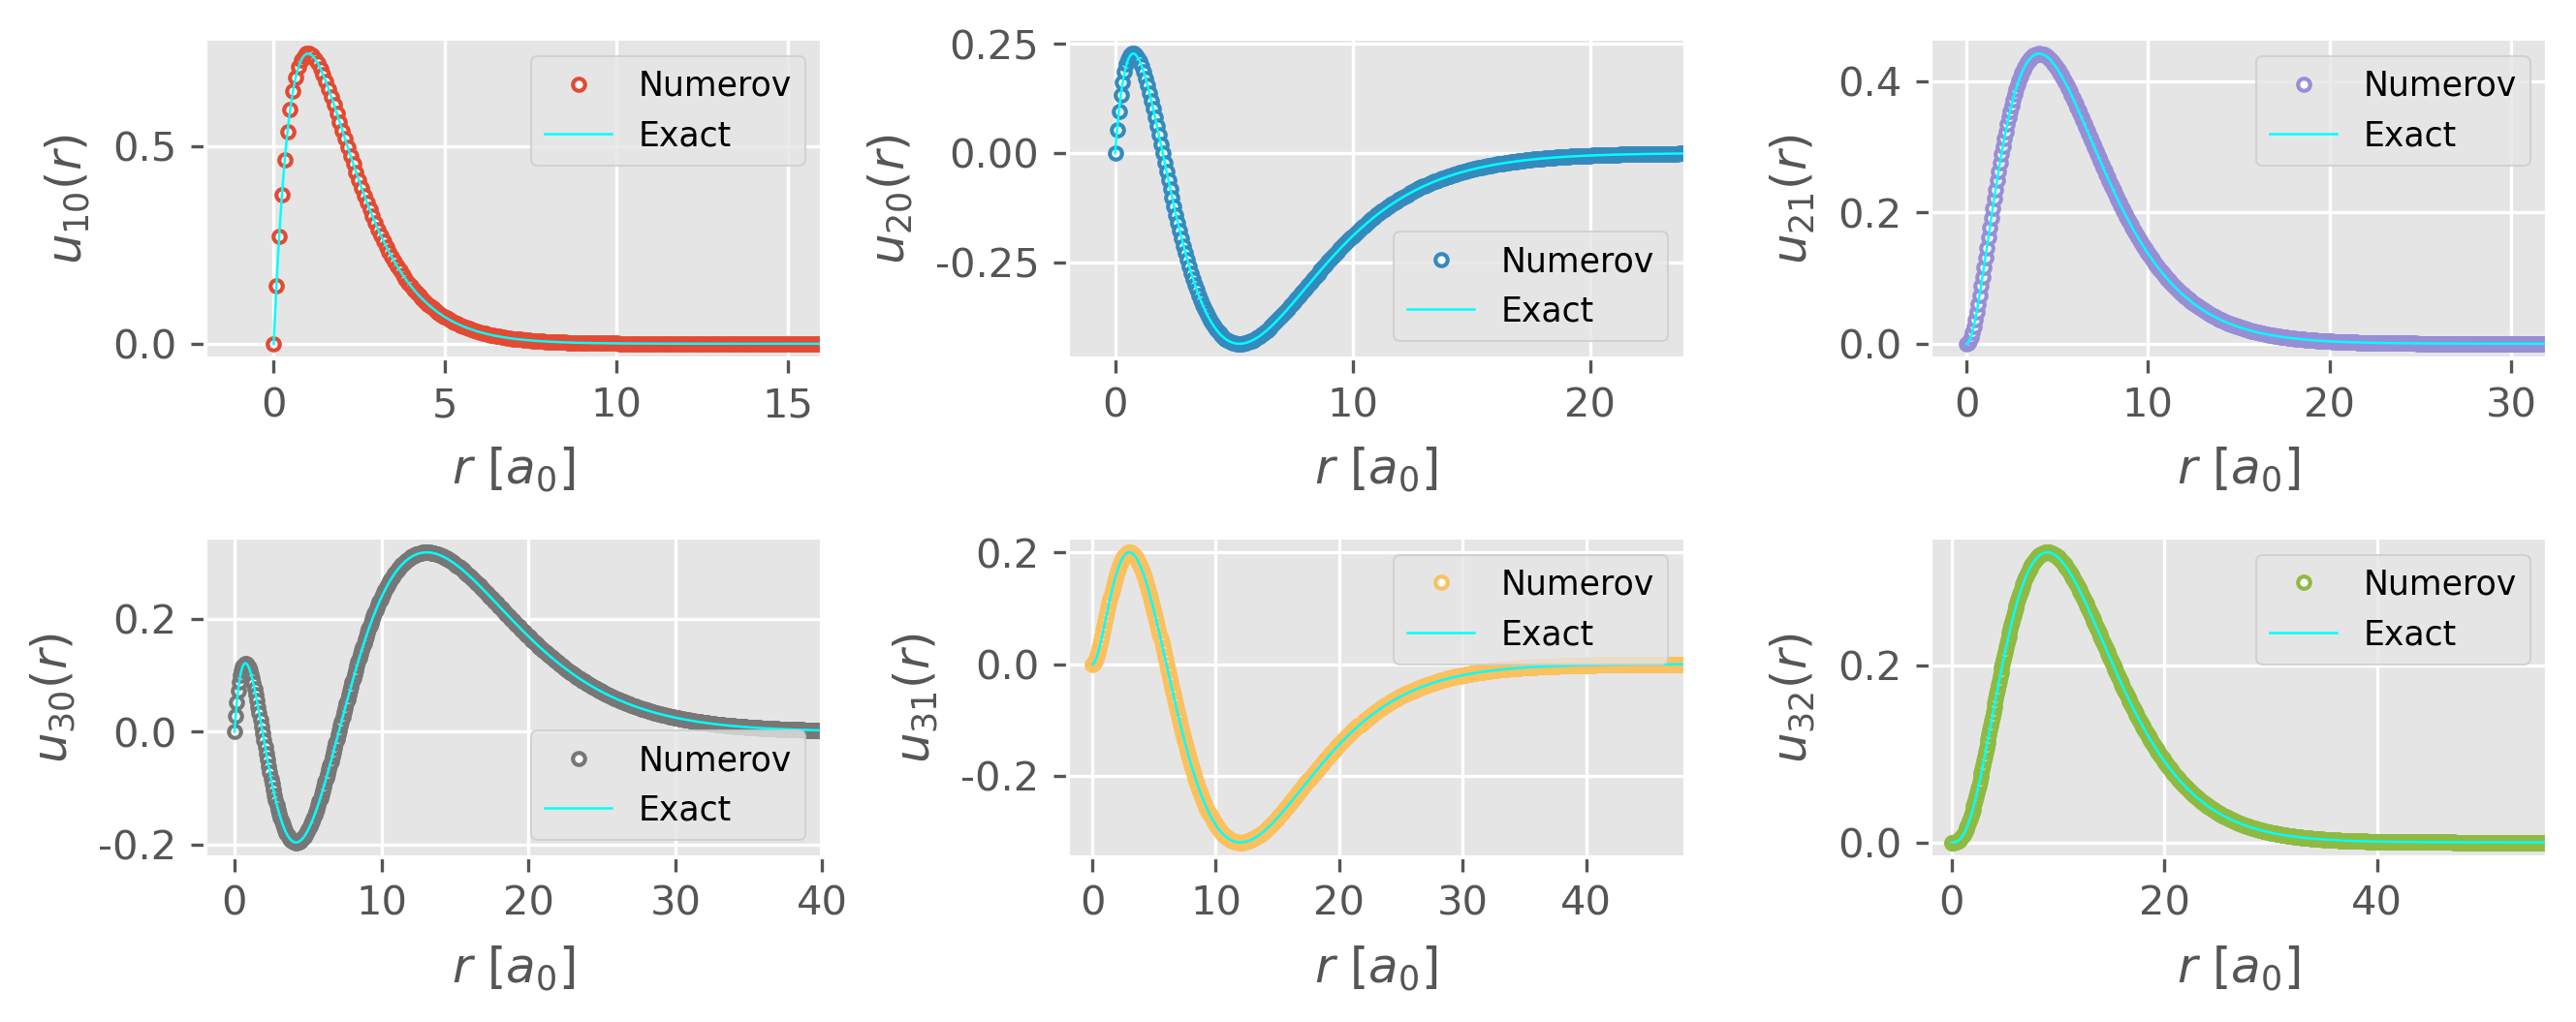

In [4]:
#!/usr/bin/env python

import numpy as np
from scipy.integrate import odeint, simps

def radial_wfc_numerov(r0, n=1, l=0, Z=1, du=0.001):
    '''
    Numerov algorithm
    
                  [12 - 10f(n)]*y(n) - y(n-1)*f(n-1)
        y(n+1) = ------------------------------------
                               f(n+1)

    where
        
        f(n) = 1 + (h**2 / 12)*g(n)

        g(n) = [E + (2*Z / x) - l*(l+1) / x**2]

    here, we use reverse integration from the other end.
    '''
    # the wavefunction
    ur = np.zeros(r0.size)
    fn = np.zeros(r0.size)

    E      = -float(Z)**2 / n**2
    ur[-1] = 0.0
    ur[-2] = du

    dr  = r0[1] - r0[0]
    h12 = dr**2 / 12.

    gn = (E + 2*Z / r0 - l*(l+1) / r0**2)
    fn = 1. + h12 * gn

    for ii in range(r0.size - 3, -1, -1):
        ur[ii] = (12 - 10*fn[ii+1]) * ur[ii+1] - \
                 ur[ii+2] * fn[ii+2]
        ur[ii] /= fn[ii]

    # normalization
    ur /= np.sqrt(simps(ur**2, x=r0))

    return ur


if __name__ == "__main__":
    ################################################################################
    r0  = np.linspace(1E-10, 80, 1000)

    nls = [
        (1, 0),
        (2, 0),
        (2, 1),
        (3, 0),
        (3, 1),
        (3, 2)
    ]

    from sympy import lambdify
    from sympy.abc import r, Z
    from sympy.physics.hydrogen import R_nl

    ur0 = [
        lambdify((r, Z), r * R_nl(n, l, r, Z), 'numpy')(r0, 1) for n, l in nls
    ]
    deltas = [0.01, -0.01, 0.01, 0.01, -0.01, 0.01]
    ur2 = [radial_wfc_numerov(r0, n, l, du=deltas[ii]) for ii, (n, l) in enumerate(nls)]

    ################################################################################
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    plt.style.use('ggplot')
    mpl.rcParams['axes.unicode_minus'] = False
    ################################################################################
    fig = plt.figure(
        figsize=(9.0, 3.6),
        dpi=300
    )
    axes = [plt.subplot(2, 3 ,ii+1) for ii in range(len(nls))]

    #################################################################################

    for ii in range(len(nls)):
        ax = axes[ii]

        ax.plot(
            r0, ur2[ii],
            ls='none',
           ms=3, marker='o', mfc='white', mew=1.0, 
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][ii],
            zorder=1,
            label=r'Numerov',
        )

        ax.plot(r0, ur0[ii], lw=0.6, color='cyan', zorder=2,
                label=r'Exact')

        ax.set_xlabel(r'$r$ [$a_0$]',   labelpad=5)
        ax.set_ylabel(r'$u_{{ {}{} }}(r)$'.format(*nls[ii]), labelpad=5)

        ax.legend(loc='best', fontsize='small', ncol=1)

        ax.set_xlim(-2, 16 + ii * 8)

    plt.tight_layout()
    plt.savefig('fig2.png')
    plt.show()

In [3]:
#!/usr/bin/env python

import numpy as np
from scipy.integrate import odeint, simps
from scipy.optimize import brentq


def radial_wfc_at0(E, r0, n=1, l=0, Z=1, du=0.01):
    '''
    Numerov algorithm
    
                  [12 - 10f(n)]*y(n) - y(n-1)*f(n-1)
        y(n+1) = ------------------------------------
                               f(n+1)

    where
        
        f(n) = 1 + (h**2 / 12)*g(n)

        g(n) = [E + (2*Z / x) - l*(l+1) / x**2]

    here, we use reverse integration from the other end.
    '''
    ur = np.zeros_like(r0)
    ur[-1] = 0.0
    ur[-2] = du

    dr  = r0[1] - r0[0]
    h12 = dr**2 / 12.
    gn  = E + 2*Z / r0 - l*(l+1) / r0**2
    fn  = 1. + h12 * gn

    for ii in range(gn.size - 3, -1, -1):
        ur[ii] = (12 - 10*fn[ii+1]) * ur[ii+1] - \
                 ur[ii+2] * fn[ii+2]
        ur[ii] /= fn[ii]

    # normalization
    ur /= np.sqrt(simps(ur**2, x=r0))

    # now extrapolate the wavefunction to u(0)
    # the first derivative equals at ur[0]
    # (u0 - ur[0]) / (0 - r0[0]) = (ur[1] - ur[0]) / (r0[1] - r0[0])
    u0 = ur[0] + (ur[1] - ur[0]) * (0 - r0[0]) / dr

    return u0


if __name__ == "__main__":
    r0 = np.linspace(1E-6, 30, 3000)

    E_lower = E_upper = -1.1
    dE      = 0.10
    u1      = radial_wfc_at0(E_lower, r0, n=1)

    while True:
        E_upper += dE
        u2 = radial_wfc_at0(E_upper, r0, n=1)
        if u1 * u2 < 0:
            break

    E = brentq(radial_wfc_at0, E_lower, E_upper, args=(r0, 1, 0, 1, 0.001)) 
    print(E)


-0.999999302182589
